# Задание 7. Исполнитель: Сафиуллин Роберт
Рассмотреть дистилляцию Хинтона как частный случай domain adaptation.
1. Обучить модель-учитель на MNIST
2. Провести дистилляцию Хинтона для модели ученика на MNIST-M

Визуализировать точность полученной модели на графике с тремя осями:
*   точность на тесте
*   температура дистилляции
*   lambda (важность слагаемого дистилляции)

Ссылки:
* [Дистилляция](https://arxiv.org/abs/1503.02531)
* [MNIST-M](https://paperswithcode.com/dataset/mnist-m)

In [1]:
import pandas as pd
import errno
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
from __future__ import print_function


In [2]:

"""Dataset setting and data loader for MNIST-M.
Modified from
https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
CREDIT: https://github.com/corenel
"""



class MNISTM(torch.utils.data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = "raw"
    processed_folder = "processed"
    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"

    def __init__(self, root, mnist_root="data", train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." + " You can use download=True to download it")

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file)
            )
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file)
            )

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and os.path.exists(
            os.path.join(self.root, self.processed_folder, self.test_file)
        )

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print("Downloading " + self.url)
        filename = self.url.rpartition("/")[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace(".gz", "")):
            data = urllib.request.urlopen(self.url)
            with open(file_path, "wb") as f:
                f.write(torch.utils.data.read())
            with open(file_path.replace(".gz", ""), "wb") as out_f, gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print("Processing...")

        # load MNIST-M images from pkl file
        with open(file_path.replace(".gz", ""), "rb") as f:
            mnist_m_data = pickle.load(f, encoding="bytes")
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b"train"])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b"test"])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root, train=True, download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root, train=False, download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root, self.processed_folder, self.training_file), "wb") as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), "wb") as f:
            torch.save(test_set, f)

        print("Done!")
        
        
def distill(labels, student_outputs, teacher_outputs, T):
    ce_loss = F.cross_entropy(student_outputs, labels)
    distill_loss = F.kl_div(
        F.log_softmax(student_outputs / T, dim=1), 
        F.softmax(teacher_outputs / T, dim=1)
    )
    return ce_loss, distill_loss
def count_params(model):
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)        
        
        
        
   

### MNIST-M переводим в чб

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_mnist_m = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Данные

In [4]:
train_set = datasets.MNIST( './data', train=True, download=True, transform=transform)
test_set =   MNISTM(root='./data', train=False, transform=transform_mnist_m, download=True)


C:\Users\safiu\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


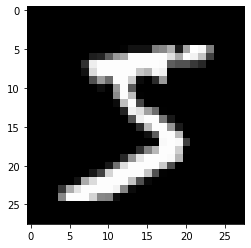

MNIST:  5


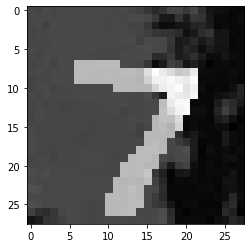

MNIST-M:  tensor(7)


In [5]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
plt.show()
print('MNIST: ',label)
image, label = next(iter(test_set))
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

print('MNIST-M: ',label)

In [10]:
batch_size = 4096
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

num_epochs = 10


### Модели

In [11]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    
    
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    
    

In [12]:
teacher = Teacher().to(device)
teacher_size = count_params(teacher)
student = Student().to(device)
student_size = count_params(student)
print(f'Соотношение параметров учитель\ученик: { student_size / teacher_size}')

Соотношение параметров учитель\ученик: 0.5330680817130857


### Обучение учителя на MNIST

In [13]:
train_set_no_distill, val_set_no_distill = torch.utils.data.random_split(train_set, [50000, 10000])
train_loader_no_distill = torch.utils.data.DataLoader(train_set_no_distill, batch_size=batch_size, shuffle=True)
test_loader_no_distill = torch.utils.data.DataLoader(val_set_no_distill, batch_size=batch_size, shuffle=True)

teacher = Teacher().to(device)
optimizer = torch.optim.Adam(teacher.parameters())
print("...Training Student Model...")
for epoch in range(num_epochs):
    teacher.train()
    total_loss = 0

    for inputs, labels in train_loader_no_distill:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().item()
        
    print(
        f"Loss: {total_loss / len(train_loader_no_distill):3f}"
    )
print("...Testing...")

teacher.eval()
num_total = 0
num_correct = 0
for inputs, labels in test_loader_no_distill:
        inputs = inputs.to(device)
        labels = labels.to(device).to(int)
        
        outputs = teacher(inputs)
        _, pred = outputs.max(1)
        num_total += len(labels)
        num_correct += (pred == labels).cpu().sum()
print(f"Accuracy: {num_correct / num_total :.3f}")

...Training Student Model...
Loss: 0.891274
Loss: 0.307621
Loss: 0.219681
Loss: 0.169390
Loss: 0.139125
Loss: 0.116375
Loss: 0.100709
Loss: 0.086130
Loss: 0.077989
Loss: 0.072655
...Testing...
Accuracy: 0.976


### Ученик на MNIST-M

In [14]:
train_set_no_distill, val_set_no_distill = torch.utils.data.random_split(test_set, [8000, 2000])
train_loader_no_distill = torch.utils.data.DataLoader(train_set_no_distill, batch_size=batch_size, shuffle=True)
test_loader_no_distill = torch.utils.data.DataLoader(val_set_no_distill, batch_size=batch_size, shuffle=True)

student_no_distill = Student().to(device)
optimizer = torch.optim.Adam(student_no_distill.parameters())

print("...Training Student Model...")
for epoch in range(num_epochs):
    student_no_distill.train()
    total_loss = 0

    for inputs, labels in train_loader_no_distill:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = student_no_distill(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().item()
        
    print(
        f"Loss: {total_loss / len(train_loader_no_distill):3f}"
    )
print("...Testing...")

student_no_distill.eval()
num_total = 0
num_correct = 0
for inputs, labels in test_loader_no_distill:
        inputs = inputs.to(device)
        labels = labels.to(device).to(int)
        
        outputs = student_no_distill(inputs)
        _, pred = outputs.max(1)
        num_total += len(labels)
        num_correct += (pred == labels).cpu().sum()
print(f"Accuracy: {num_correct / num_total :.3f}")

...Training Student Model...
Loss: 2.383654
Loss: 2.255507
Loss: 2.126967
Loss: 1.986381
Loss: 1.858083
Loss: 1.739050
Loss: 1.644680
Loss: 1.564844
Loss: 1.514424
Loss: 1.460433
...Testing...
Accuracy: 0.502


### Сетка параметров дистилляции

In [15]:


lambdas = np.linspace(0.3,0.9,5)
temps = np.array([0.01, 0.1, 1,10,20,50,100,1000])

num_epochs = 10
accs = []

### Дистилляция

In [16]:
# teacher.eval()
for lambda_,T in list(itertools.product(lambdas, temps)):
    student = Student().to(device)
    optimizer = torch.optim.Adam(student.parameters())
    print("...Distilling Student Model...")
    for epoch in range(num_epochs):
        student.train()
        
        total_ce_loss = 0
        total_distill_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

            ce_loss, distill_loss = distill(labels, student_outputs, teacher_outputs, T)
            loss = (1 - lambda_) * ce_loss + (lambda_ * T ** 2) * distill_loss
            loss.backward()
            optimizer.step()

            total_ce_loss += ce_loss.cpu().item()
            total_distill_loss += distill_loss.cpu().item()

        print(
            f"Distill Loss: {total_distill_loss / len(train_loader):3f}, "
            f"CE Loss: {total_ce_loss / len(train_loader):.3f}"
        )
    print("...Testing...")
    print (T,lambda_)
    student.eval()
    num_total = 0
    num_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).to(int)

            outputs = student(inputs)
            _, pred = outputs.max(1)
            num_total += len(labels)
            num_correct += (pred == labels).cpu().sum()
        print(f"Accuracy: {num_correct / num_total :.3f}")
    accs.append(num_correct / num_total)

...Distilling Student Model...


C:\Users\safiu\anaconda3\lib\site-packages\torch\nn\functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Distill Loss: 2.066689, CE Loss: 0.824
Distill Loss: 1.491583, CE Loss: 0.296
Distill Loss: 0.672072, CE Loss: 0.198
Distill Loss: 0.401003, CE Loss: 0.147
Distill Loss: 0.248350, CE Loss: 0.115
Distill Loss: 0.157791, CE Loss: 0.090
Distill Loss: 0.108254, CE Loss: 0.074
Distill Loss: 0.082087, CE Loss: 0.059
Distill Loss: 0.094884, CE Loss: 0.050
Distill Loss: 0.104133, CE Loss: 0.042
...Testing...
0.01 0.3
Accuracy: 0.279
...Distilling Student Model...
Distill Loss: 0.219437, CE Loss: 0.832
Distill Loss: 0.155976, CE Loss: 0.304
Distill Loss: 0.078876, CE Loss: 0.211
Distill Loss: 0.044233, CE Loss: 0.154
Distill Loss: 0.026635, CE Loss: 0.118
Distill Loss: 0.017391, CE Loss: 0.094
Distill Loss: 0.012127, CE Loss: 0.076
Distill Loss: 0.009921, CE Loss: 0.064
Distill Loss: 0.008454, CE Loss: 0.051
Distill Loss: 0.010183, CE Loss: 0.043
...Testing...
0.1 0.3
Accuracy: 0.301
...Distilling Student Model...
Distill Loss: 0.073993, CE Loss: 0.821
Distill Loss: 0.020497, CE Loss: 0.295
Dis

Distill Loss: 0.009799, CE Loss: 0.042
...Testing...
0.1 0.6000000000000001
Accuracy: 0.284
...Distilling Student Model...
Distill Loss: 0.073282, CE Loss: 0.813
Distill Loss: 0.019675, CE Loss: 0.287
Distill Loss: 0.011305, CE Loss: 0.197
Distill Loss: 0.006754, CE Loss: 0.145
Distill Loss: 0.003986, CE Loss: 0.110
Distill Loss: 0.002601, CE Loss: 0.088
Distill Loss: 0.001813, CE Loss: 0.072
Distill Loss: 0.001403, CE Loss: 0.058
Distill Loss: 0.001336, CE Loss: 0.049
Distill Loss: 0.001385, CE Loss: 0.040
...Testing...
1.0 0.6000000000000001
Accuracy: 0.281
...Distilling Student Model...
Distill Loss: 0.008227, CE Loss: 0.852
Distill Loss: 0.002422, CE Loss: 0.326
Distill Loss: 0.001198, CE Loss: 0.222
Distill Loss: 0.000620, CE Loss: 0.157
Distill Loss: 0.000351, CE Loss: 0.118
Distill Loss: 0.000232, CE Loss: 0.094
Distill Loss: 0.000168, CE Loss: 0.079
Distill Loss: 0.000136, CE Loss: 0.068
Distill Loss: 0.000118, CE Loss: 0.060
Distill Loss: 0.000104, CE Loss: 0.054
...Testing...

Distill Loss: 0.000338, CE Loss: 0.140
Distill Loss: 0.000219, CE Loss: 0.116
Distill Loss: 0.000157, CE Loss: 0.100
Distill Loss: 0.000122, CE Loss: 0.089
Distill Loss: 0.000100, CE Loss: 0.081
Distill Loss: 0.000084, CE Loss: 0.075
...Testing...
10.0 0.9
Accuracy: 0.299
...Distilling Student Model...
Distill Loss: 0.001793, CE Loss: 0.960
Distill Loss: 0.000517, CE Loss: 0.370
Distill Loss: 0.000245, CE Loss: 0.249
Distill Loss: 0.000123, CE Loss: 0.174
Distill Loss: 0.000071, CE Loss: 0.134
Distill Loss: 0.000047, CE Loss: 0.111
Distill Loss: 0.000034, CE Loss: 0.096
Distill Loss: 0.000026, CE Loss: 0.086
Distill Loss: 0.000022, CE Loss: 0.078
Distill Loss: 0.000019, CE Loss: 0.072
...Testing...
20.0 0.9
Accuracy: 0.293
...Distilling Student Model...
Distill Loss: 0.000260, CE Loss: 0.974
Distill Loss: 0.000081, CE Loss: 0.379
Distill Loss: 0.000039, CE Loss: 0.254
Distill Loss: 0.000020, CE Loss: 0.181
Distill Loss: 0.000012, CE Loss: 0.140
Distill Loss: 0.000008, CE Loss: 0.114
Di

Text(0.5, 0.92, 'Task7')

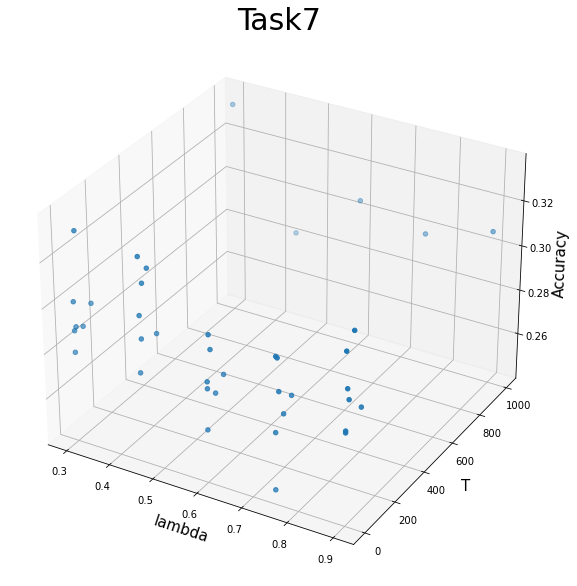

In [17]:
arr = list(itertools.product(lambdas, temps))
df = pd.DataFrame(np.vstack((np.array(arr).reshape(len(arr),2)[:,0],np.array(arr).reshape(len(arr),2)[:,1],
     np.array(accs))).T,columns = ['lambda','T','Accuracy'])

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['lambda'], df['T'], df['Accuracy'])
ax.set_xlabel('lambda', fontsize = 15)
ax.set_ylabel('T', fontsize = 15)
ax.set_zlabel('Accuracy', fontsize = 15)
ax.set_title('Task7', fontsize = 30)


In [19]:

fig = px.scatter_3d(df, x='lambda', y='T', z='Accuracy'
                   ,title = 'Task7')
fig.show()

### Явного тренда не наблюдается, что может быть следствием плохого выбора архитектур нейросети (максимальаня точность при дистилляции ~ 33%). Просадки метрики наблюдаются в районе  $\lambda$ ~ 0.6. 

При большИх размерах батча наилучшие модели находились в области $ \lambda > 0.6 $